<a href="https://colab.research.google.com/github/Smooj/Data-Science/blob/main/Twitter_Sentiment_Analysis_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Twitter Sentiment Analysis**

---


Objective: Build a model that will classify tweets as positive or negative. This can be used to help determine the reputation of a brand (PR), monitor customer satisfaction levels, and help determine the reputation of competing brands.

This project is to help classify the emotion the user depicted with their tweet using a logistic regression model. I will use the Sentiment140 Dataset from Kaggle.



In [ ]:
#Download all libaries
#Pip installs:
!pip install kaggle
!pip install wordcloud
from wordcloud import WordCloud

#Impoting libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re #regular expression to help us find patterns in the data
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer #reduce the words to root words
from sklearn.feature_extraction.text import TfidfVectorizer #need to convert out text data to numerical data
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression #ML model
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import nltk
nltk.download('stopwords') #words that add no value to our model words like I, me, you, etc
import seaborn as sns
from dateutil import parser

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Uploading Dataset from Kaggle.

Obtain the Twitter Sentiment dataset from kaggle using json.

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                                 title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rabieelkharoua/students-performance-dataset                         📚 Students Performance Dataset 📚                     66KB  2024-06-12 23:09:20          10069        211  1.0              
nelgiriyewithana/most-streamed-spotify-songs-2024                   Most Streamed Spotify Songs 2024                    496KB  2024-06-15 18:50:51           7835        165  1.0              
humairmunir/anaemia-prediction                                      Anaemia Prediction                                    2KB  2024-07-04 17:58:40            601         26  1.0              
ihelon/coffee-sales                     

In [ ]:
# Use API to obtain dataset from kaggle
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 70% 57.0M/80.9M [00:00<00:00, 147MB/s]
100% 80.9M/80.9M [00:00<00:00, 163MB/s]


In [ ]:
#extract the data from compressed dataset
from zipfile import ZipFile
file_name = "sentiment140.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")


Done


In [ ]:
#Load the file
headers = ["target","ids","date","flag","user","text"]
df = pd.read_csv('training.1600000.processed.noemoticon.csv', names=headers, encoding='ISO-8859-1') #encoding
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Explore Dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
df.shape

(1600000, 6)

There are 1600000 tweets and 6 columns. The most important columns for this analysis are the text column which contains all the tweets and the target column which contains whether the tweet is positive or negative.

In [ ]:
#Check for missing values
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

There are no missing values in the dataset

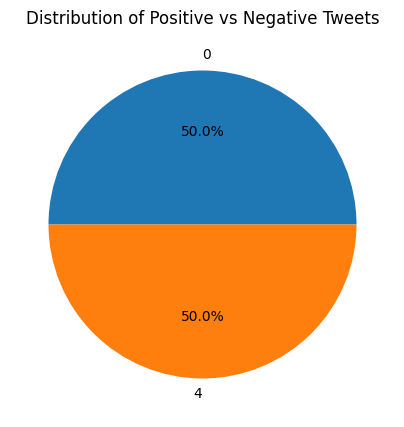

In [ ]:
#check the distribution of our target
df['target'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(5,5))
plt.title('Distribution of Positive & Negative Tweets')
plt.ylabel(None)
plt.show()
None

The data has been equally distribution of tweets
*   0 means negative tweets

*   4 means positive tweet

Change the target variables to -1 for negative tweets and 1 for positive tweets

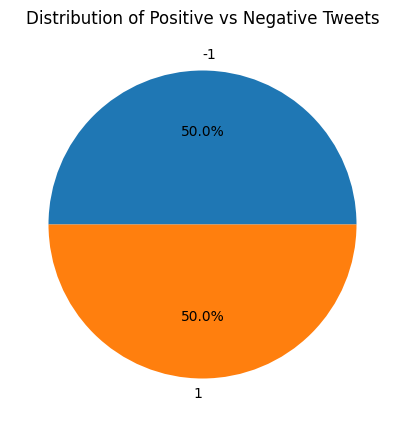

In [ ]:
#Rename the lables
df.loc[df['target'] == 4, 'target'] = 1
df.loc[df['target'] == 0, 'target'] = -1
df['target'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(5,5))
plt.title('Distribution of Positive & Negative Tweets')
plt.ylabel(None)
plt.show()
None

### Exploratory Data Analysis

---



*   Explore the date to see what year and months we have the most tweets.
*   What words are more common in positive tweets vs negative tweets



In [ ]:
# Convert the date from series to dataframe
dates = pd.DataFrame(df['date'])
new_date = []
for date in dates['date']:
  updated_date = parser.parse(date, tzinfos={"PDT":-7*3600}) #convert the timezone to UTC
  new_date.append(updated_date)
dates['date'] = new_date
dates['date'].dt.year.unique() #determine all the unqiue years

array([2009], dtype=int32)

All the tweets are from 2009

In [ ]:
dates['date'].dt.month.unique() #what months make up the dataset

array([4, 5, 6], dtype=int32)

The tweets are from April-June 2009

## Preprocessing Text Data

---
To analyze the tweets, we need to clean the text data. This will consist of removing words that don't entail any emotion such as stopwords. I will also convert the words to their root words through the process of stemming. I will also need to represent the text numerical to run it through the logistic regression model (Vectorization).


*   Stemming
*   Vectorization





**Stemming** - process of reducing words to their root word (simplifying the words)

Actor, actress and acting have the same meaning so we can reduce them to the root word, act.

This reduces the complexity of the dataset. Helps reduce the number of dimensions we have to work with.

In [ ]:
port_stem = PorterStemmer()

def stemming(text):
  """
  Function that reduces the words to their root word, removes puncations and stop words.
  Returning a sentence in its reduced form.
  """
  stemmed_text = re.sub(r'[^a-zA-Z]',' ',text) #remove any characters that are in the alphabet (i.e. will remove @,#,!)
  stemmed_text = stemmed_text.lower() #covert all uppercase letters to lowecase
  stemmed_text = stemmed_text.split() #split the words and store in a list
  stemmed_text = [port_stem.stem(word) for word in stemmed_text if not word in stopwords.words('english')] #remove the stop words from the list
  stemmed_text = ' '.join(stemmed_text) #rejoin the words to create the sentence again
  return stemmed_text

In [ ]:
df['stemmed_text'] = df['text'].apply(stemming) #will take 50mins to complete this step
df.head()

,target,ids,date,flag,user,text,stemmed_text
0,-1,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,-1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,-1,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,-1,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,-1,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


What words make up a positive tweet vs a negative tweet

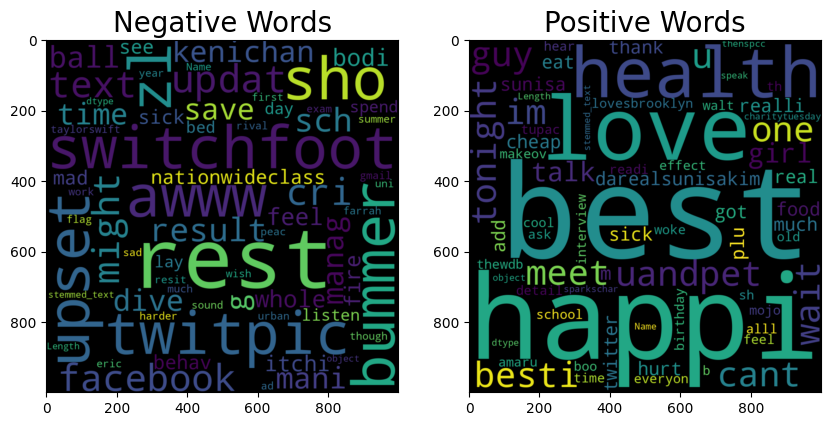

<Figure size 640x480 with 0 Axes>

In [ ]:
#Create a wordcloud of postive tweets vs Negative tweets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
word_cloud_negative = WordCloud(width=1000, height=1000,
                       max_words=100,
                       min_font_size=10).generate(str(df[df['target']==-1]['stemmed_text']))
ax1.imshow(word_cloud_negative, interpolation='bilinear')
ax1.set_title("Negative Words", fontsize=20)

word_cloud_positive = WordCloud(width=1000, height=1000,
                       max_words=100,
                       min_font_size=10).generate(str(df[df['target']==1]['stemmed_text']))
ax2.imshow(word_cloud_positive, interpolation='bilinear')
ax2.set_title("Positive Words", fontsize=20)
plt.show()
plt.tight_layout()
None

Negative words: rest, bummer, upset, and awww
- It's interesting that Facebook is linked with negative words

Positive words: best, happy, love, and health. These words make sense to be positive.


**Vectorization** - convert the text from words to numbers to use it in our ML model. I will use the TFvectorizer which convert the text to a matrix of TF-IDF features.

Term Frequency-Inverse Document Frequency (TF-IDF) - measures the importance of a word in the context of the corpus (tweet).


In [ ]:
#Creating my x values and y values
X = df['stemmed_text'].values #should be an array to run ML models
y = df['target'].values #should be an array

In [ ]:
#split the data into test and train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(1600000,) (1280000,) (320000,)
(1600000,) (1280000,) (320000,)


In [ ]:
TFvectorizer = TfidfVectorizer()
X_train = TFvectorizer.fit_transform(X_train)
X_test = TFvectorizer.transform(X_test)

In [ ]:
print(X_train)
#The words get a particular value based on their reputation in the dataset

  (0, 443066)	0.4484755317023172
  (0, 235045)	0.41996827700291095
  (0, 109306)	0.3753708587402299
  (0, 185193)	0.5277679060576009
  (0, 354543)	0.3588091611460021
  (0, 436713)	0.27259876264838384
  (1, 160636)	1.0
  (2, 288470)	0.16786949597862733
  (2, 132311)	0.2028971570399794
  (2, 150715)	0.18803850583207948
  (2, 178061)	0.1619010109445149
  (2, 409143)	0.15169282335109835
  (2, 266729)	0.24123230668976975
  (2, 443430)	0.3348599670252845
  (2, 77929)	0.31284080750346344
  (2, 433560)	0.3296595898028565
  (2, 406399)	0.32105459490875526
  (2, 129411)	0.29074192727957143
  (2, 407301)	0.18709338684973031
  (2, 124484)	0.1892155960801415
  (2, 109306)	0.4591176413728317
  (3, 172421)	0.37464146922154384
  (3, 411528)	0.27089772444087873
  (3, 388626)	0.3940776331458846
  (3, 56476)	0.5200465453608686
  :	:
  (1279996, 390130)	0.22064742191076112
  (1279996, 434014)	0.2718945052332447
  (1279996, 318303)	0.21254698865277746
  (1279996, 237899)	0.2236567560099234
  (1279996, 2910

## Logistic Regression Model

---



Classify the tweets as positive or negative.

To evaluate the model I will use accuracy, recall, precision, F1 scores, and a confusion matrix.

*   Accuracy Score: Number of correct predictions over all predictions.
*   Precision Score: Ratio between True Positives and all positives (True positives + false positives).
*   Recall Score: Ratio between true positives and (true positives + false negatives).
*   F1 Score: Average precision and recall
*   Confusion Matrix: Matrix to show the TP,FP,FN,TN



In [ ]:
#Create instance of model and fit the train set to the model
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [ ]:
#Evaluate the model on the train data
X_train_pred = model.predict(X_train)
print('Accuracy Score: ', accuracy_score(X_train_pred, y_train))
print('Precision Score: ', precision_score(X_train_pred, y_train))
print('Recall Score: ', recall_score(X_train_pred, y_train))
print('F1 Score: ', f1_score(X_train_pred, y_train))
print('Confusion Matrix:\n', confusion_matrix(X_train_pred, y_train))

Accuracy Score:  0.81018984375
Precision Score:  0.8307890625
Recall Score:  0.7979161633154103
F1 Score:  0.8140208685614378
Confusion Matrix:
 [[505338 108295]
 [134662 531705]]


In [ ]:
X_test_pred = model.predict(X_test)
print('Accuracy Score: ', accuracy_score(X_test_pred, y_test))
print('Precision Score: ', precision_score(X_test_pred, y_test))
print('Recall Score: ', recall_score(X_test_pred, y_test)) #l3l3
print('F1 Score: ', f1_score(X_test_pred, y_test))
print('Confusion Matrix:\n', confusion_matrix(X_test_pred, y_test))

Accuracy Score:  0.7780375
Precision Score:  0.79704375
Recall Score:  0.7678556375766188
F1 Score:  0.7821774890978344
Confusion Matrix:
 [[121445  32473]
 [ 38555 127527]]


Overall, the baseline model is doing really well. The accuracy, precision, recall, and F1 scores are around 75-80% indicating that our model is accurately predicting the tweets.

The training accuracy is slightly higher than the test accuracy indicating that our baseline logistic regression model is slightly overfitting the data. Let's fine-tune the model to see if the model stops overfitting and the accuracy on the test set improves.


## Fine-tune Logistic Regression Model

---

To will use a grid search to determine the best C, and penalty type to prevent overfitting while obtaining the highest accuracy score.

C parameter determines the strength of the regularization. Smaller values lead to stronger regularization and larger values leads to weaker regularization.

Penalty - L1 vs L2.


*   L1 penalty - penalizes the sum of absolute values of the weights
*   L2 penalty - penalizes the sum of the squares of the weights


In [ ]:
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5],
             'penalty': ['l1','l2'],
              'solver':['saga']} #
grid_search = GridSearchCV(estimator = model,
                           param_grid=param_grid,
                           scoring='accuracy',
                           verbose=3,
                           cv=5)
grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
print(best_parameters)
best_model = grid_search.best_estimator_
print(best_model)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .C=0.0001, penalty=l1, solver=saga;, score=0.500 total time=   6.0s
[CV 2/5] END .C=0.0001, penalty=l1, solver=saga;, score=0.500 total time=  10.6s
[CV 3/5] END .C=0.0001, penalty=l1, solver=saga;, score=0.500 total time=  11.1s
[CV 4/5] END .C=0.0001, penalty=l1, solver=saga;, score=0.500 total time=  11.5s
[CV 5/5] END .C=0.0001, penalty=l1, solver=saga;, score=0.500 total time=   9.4s
[CV 1/5] END .C=0.0001, penalty=l2, solver=saga;, score=0.713 total time= 1.2min
[CV 2/5] END .C=0.0001, penalty=l2, solver=saga;, score=0.713 total time= 1.2min
[CV 3/5] END .C=0.0001, penalty=l2, solver=saga;, score=0.715 total time= 1.1min
[CV 4/5] END .C=0.0001, penalty=l2, solver=saga;, score=0.712 total time= 1.2min
[CV 5/5] END .C=0.0001, penalty=l2, solver=saga;, score=0.714 total time= 1.2min
[CV 1/5] END ..C=0.001, penalty=l1, solver=saga;, score=0.628 total time=  27.3s
[CV 2/5] END ..C=0.001, penalty=l1, solver=saga;

The optimial model will have a C value of 0.5, use L2 penalty, with a saga solver.

In [ ]:
X_test_pred = best_model.predict(X_test)
training_score = accuracy_score(X_test_pred, y_test)
print('Accuracy Score: ', accuracy_score(X_test_pred, y_test))
print('Precision Score: ', precision_score(X_test_pred, y_test))
print('Recall Score: ', recall_score(X_test_pred, y_test)) #l3l3
print('F1 Score: ', f1_score(X_test_pred, y_test))
print('Confusion Matrix:\n', confusion_matrix(X_test_pred, y_test))

Accuracy Score:  0.7773625
Precision Score:  0.79904375
Recall Score:  0.7658352202614144
F1 Score:  0.7820871235524779
Confusion Matrix:
 [[120909  32153]
 [ 39091 127847]]


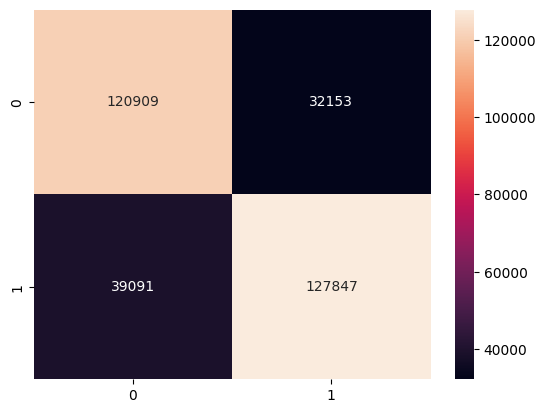

In [ ]:
sns.heatmap(confusion_matrix(X_test_pred, y_test), annot=True, fmt='d')
None

After fine-tuning our baseline logistic regression model the scores are similar to our baseline model. A F1 score 78% indicates that our model is doing really well at classifying the tweets as positive and negative.

To further enhance the model, I would consider converting emojis into text rather than removing them from the data. Emojis hold a lot of information in terms of emotion that would help the classifier improves its scores. I would also like to run more advanced classifiers just as Random Forest, XGBoost, or neural networks however my colab kept crashing due to the size of the dataset.

To enhance the project, I would consider obtaining tweets about various competing brands or subjects and do a brand analysis. I would also like to obtain tweets from a longer time period and see how sentiment has changed over time.


### Hide

In [ ]:
import pickle
filename = 'LogRegTrained_model.sav'
pickle.dump(model, open(filename, 'wb'))

Loading saved model

In [ ]:
loded_model = pickle.load(open('LogRegTrained_model.sav', 'rb'))

Running a random forest model


- Taking too long to run
- Colab keeps crashing

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

RF_model = RandomForestClassifier(n_estimators=100, random_state=42)
RF_model.fit(X_train, y_train)



In [ ]:
X_train_pred = RF_model.predict(X_train)
training_score = accuracy_score(X_train_pred, y_train)
print('Accuracy Score: ', round(training_score,3)*100)

In [ ]:
GB_model = GradientBoostingClassifier()
GB_model.fit(X_train, y_train)

In [ ]:
X_train_pred = GB_model.predict(X_train)
training_score = accuracy_score(X_train_pred, y_train)
print('Accuracy Score: ', round(training_score,3)*100)

In [ ]:
import pickle
loded_model = pickle.load(open('LogRegTrained_model.sav', 'rb'))

In [ ]:
incorrectly_classified = []
for i in range(len(X_test_pred)):
  if X_test_pred[i] != y_test[i]:
    incorrectly_classified.append(X_test[i])

incorrectly_classified = pd.DataFrame(incorrectly_classified)
incorrectly_classified.head()

,0
0,"(0, 420984)\t0.17915624523539803\n (0, 4091..."
1,"(0, 80675)\t0.6549695049229287\n (0, 53764)..."
2,"(0, 453642)\t0.32406517037419635\n (0, 4445..."
3,"(0, 426495)\t0.40238506482457836\n (0, 4264..."
4,"(0, 438748)\t0.14659942107453744\n (0, 4376..."


In [ ]:
X_test_pred[1]

1

hey, hello